# Execution of Dreambooth Stable Diffusion



Tutorials and prompts at [stable-diffusion-art.com](https://stable-diffusion-art.com)

The latest copy can be found [here](https://colab.research.google.com/github/sagiodev/stablediffusion_webui/blob/master/DreamBooth_Stable_Diffusion_SDA.ipynb).

Modified from [Shivam Shrirao](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)'s repo.

Instructions - See [acommpanying article](https://stable-diffusion-art.com/dreambooth/) for step-by-step walkthrough. Leave comment under article if you have any questions.
1. Make sure your Google Drive has at least 2GB (4GB if `fp16` is not checked)
2. Prepare you custom image to be 512x512 pixels.
1. Run the first cell by clicking the play button.
2. Grant access to Google Drive.
3. Click "Choose files" to upload your images
4. After it is complete (800 steps should take 30 mins), go to your [Google Drive](https://drive.google.com/drive/my-drive) to download your model in folder Dreambooth_model
5. Use the 2nd cell to generate new images using the new model.

This code is not written by me. It was written by a youtuber - WizzityGen. I've used it for this project to test a relevant model 


Mounted at /content/drive
Tesla T4, 15360 MiB, 15101 MiB
[*] Weights will be saved at /content/stable_diffusion_weights/output
Uploading instance images for `in indo_style`


Saving indo_style(1).jpg to indo_style(1).jpg
Saving indo_style(2).jpg to indo_style(2).jpg
Saving indo_style(3).jpg to indo_style(3).jpg
Saving indo_style(4).jpg to indo_style(4).jpg
Saving indo_style(5).jpg to indo_style(5).jpg
Saving indo_style(6).jpg to indo_style(6).jpg
Saving indo_style(7).jpg to indo_style(7).jpg
Saving indo_style(8).jpg to indo_style(8).jpg
Saving indo_style(9).jpg to indo_style(9).jpg
Saving indo_style(10).jpg to indo_style(10).jpg
Saving indo_style(11).jpg to indo_style(11).jpg
Saving indo_style(12).jpg to indo_style(12).jpg
Saving indo_style(13).jpg to indo_style(13).jpg
Saving indo_style(14).jpg to indo_style(14).jpg
Saving indo_style(15).jpg to indo_style(15).jpg
Saving indo_style(16).jpg to indo_style(16).jpg
Saving indo_style(17).jpg to indo_style(17).jpg
Saving indo_style(18).jpg to indo_style(18).jpg
Saving indo_style(19).jpg to indo_style(19).jpg
Saving indo_style(20).jpg to indo_style(20).jpg
Saving indo_style(21).jpg to indo_style(21).jpg
Saving ind

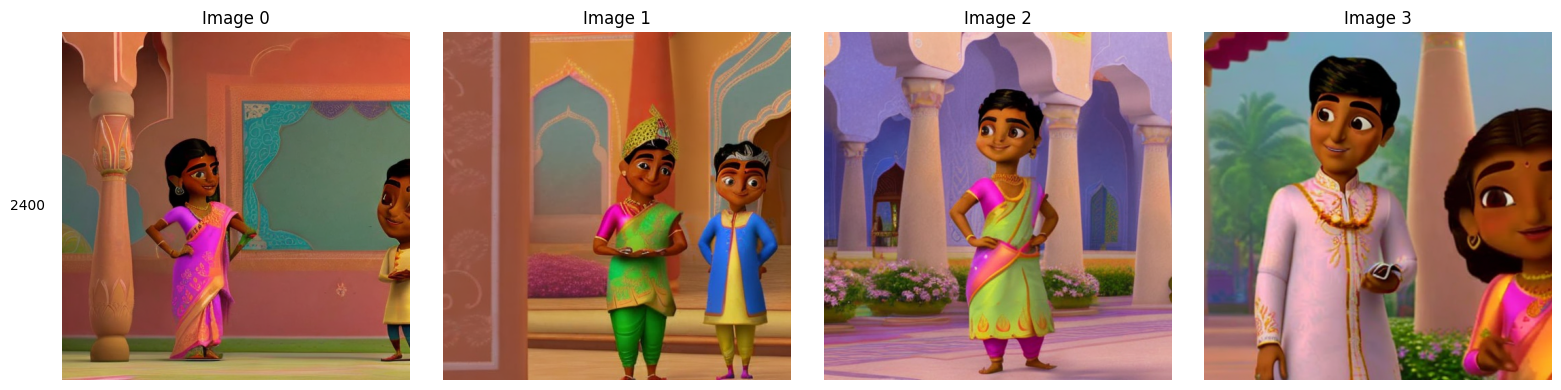

In [ ]:
import time
time_start = time.time()
#@title DreamBooth
HUGGINGFACE_TOKEN = ""

#@markdown Name/Path of the initial model. (Find model name [here](https://huggingface.co/models))
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}
BRANCH = "fp16" #@param {type:"string"}

#@markdown Enter instance prompt and class prompt.\
#@markdown Example 1: photo of zwx person, photo of a person\
#@markdown Example 2: photo of zwx toy, photo of a toy
instance_prompt = "in indo_style" #@param {type:"string"}
class_prompt =  "illustration style" #@param {type:"string"}
training_steps = 2400 #@param {type:"integer"}
learning_rate = 1e-6 #@param {type:"number"}

#@markdown  Convert to fp16? (takes half the space (2GB)).
fp16 = True #@param {type: "boolean"}
#@markdown  Compile xformers (Try only if you see xformers error. Will take 1 more hour).
complie_xformers = False #@param {type: "boolean"}

save_to_gdrive = True
from google.colab import drive
if save_to_gdrive:
  drive.mount('/content/drive')


#@markdown Clear log after run?
CLEAR_LOG = False #@param {type:"boolean"}


OUTPUT_DIR = "stable_diffusion_weights/output"
OUTPUT_DIR = "/content/" + OUTPUT_DIR

# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR


# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
    {
        "instance_prompt":      instance_prompt,
        "class_prompt":         class_prompt,
        "instance_data_dir":    "/content/data/instance",
        "class_data_dir":       "/content/data/class"
    },
#     {
#         "instance_prompt":      "photo of ukj person",
#         "class_prompt":         "photo of a person",
#         "instance_data_dir":    "/content/data/ukj",
#         "class_data_dir":       "/content/data/person"
#     }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)


import os
from google.colab import files
import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)


def clear():
    from IPython.display import clear_output; return clear_output()



# huggingface token
!mkdir -p ~/.huggingface
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token


# install repos
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
#%pip install torch==2.0.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers
# install xformer wheel
print('Install xformers')
if complie_xformers:
  %pip install git+https://github.com/facebookresearch/xformers@4c06c79#egg=xformers
#else:
#  %pip install  --no-deps -q https://github.com/brian6091/xformers-wheels/releases/download/0.0.15.dev0%2B4c06c79/xformers-0.0.15.dev0+4c06c79.d20221205-cp38-cp38-linux_x86_64.whl
#%pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/4c06c79_various6/xformers-0.0.15.dev0_4c06c79.d20221201-cp38-cp38-linux_x86_64.whl
#%pip install -q https://github.com/ShivamShrirao/xformers-wheels/releases/download/4c06c79/xformers-0.0.15.dev0+4c06c79.d20221201-cp38-cp38-linux_x86_64.whl


############## Edit this section to customize parameters
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision=$BRANCH \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=$training_steps \
  --save_interval=10000 \
  --save_sample_prompt="$instance_prompt" \
  --concepts_list="concepts_list.json"

########################################

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

from natsort import natsorted
from glob import glob
import os
weightdirs = natsorted(glob(OUTPUT_DIR + os.sep + "*"))
if len(weightdirs) == 0:
  raise KeyboardInterrupt("No training weights directory found")
WEIGHTS_DIR = weightdirs[-1]


ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")


if CLEAR_LOG:
  clear()

print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')

plt.tight_layout()
plt.savefig('grid.png', dpi=72)

if save_to_gdrive:
  import os.path
  gPath = "/content/drive/MyDrive/Dreambooth_model"
  !mkdir -p $gPath
  filename = 'model.ckpt'
  i = 1
  ckpt_gpath = gPath + '/' + filename
  while os.path.isfile(ckpt_gpath):
    filename = 'model%d.ckpt'%i
    ckpt_gpath = gPath + '/' + filename
    i += 1
  ckpt_gpath = gPath + '/' + filename
  !cp $ckpt_path $ckpt_gpath
  print('Model saved to %s'%ckpt_gpath)


### TESTING THE MODEL

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

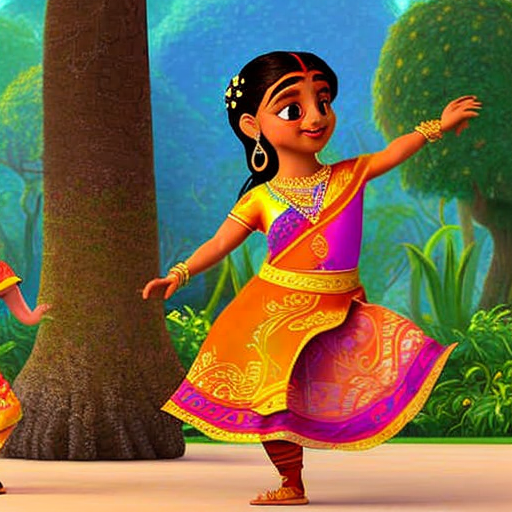

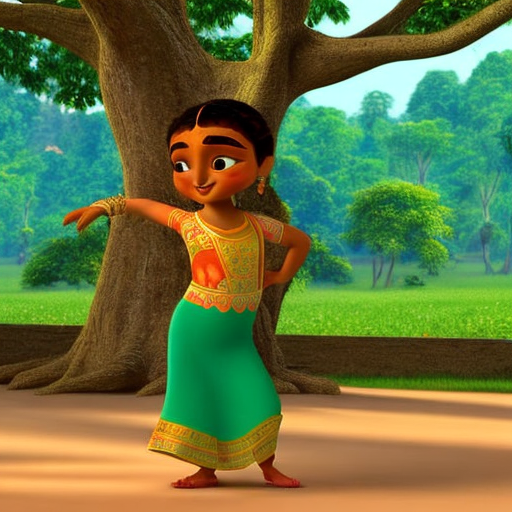

In [6]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display


prompt = "A girl dancing in a forest with a a tiger, in indo_style" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 2 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 30 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
seed = 100 #@param {type:"number"}


model_path = "/content/drive/MyDrive/Dreambooth_model/model.ckpt"
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_single_file(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")

g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)